In [1]:
import pandas as pd
import tensorflow as tf
import keras
import os.path
import numpy as np

from keras.utils import np_utils
from datetime import datetime
from sklearn.model_selection import train_test_split

from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from IPython.core.debugger import Tracer

from imblearn.over_sampling import SMOTE

print(tf.VERSION)
print(keras.__version__)

C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1.9.0
2.2.2


# Read-in data

In [4]:
train_pd = pd.read_csv('./datasets/train.csv', sep=',', header=0)

## Getting to know the data

Check if there is more than 1 household head per household

Group by *idhogar* (household key) and then check column *parentesco1*

In [ ]:
idhogar_aggregated = train_pd.groupby('idhogar').parentesco1.sum()

In [ ]:
idhogar_aggregated[idhogar_aggregated != 1]

There are 15 households with no household head

Check if the poverty label is the same for all members of a household

In [ ]:
target_aggregated = train_pd.groupby('idhogar').Target.aggregate(['min', 'max'])

target_aggregated['poverty_different'] = target_aggregated['min'] != target_aggregated['max']
target_aggregated.loc[target_aggregated['poverty_different']].head(10)

It is not, meaning that members of a given household can have different poverty levels.

In [ ]:
train_pd.loc[train_pd['idhogar'] == '0172ab1d9']

Check if houses that have been fully paid have a montly payment - they should not.

In [ ]:
train_pd.loc[(train_pd['tipovivi1'] == 1) & (~np.isnan(train_pd['v2a1']))] # GOOD

In [ ]:
len(train_pd.columns)

# Prepare data

Drop some unneeded columns

In [5]:
# the columns (SQBage, agesq) and (tamhog, hhsize, hogar_total) are identical - REMOVE THEM
train_pd.drop(columns=['SQBage', 'tamhog', 'hogar_total'], inplace=True)
# drop interaction columns ['edjefe', 'edjefa']
train_pd.drop(columns=['edjefe', 'edjefa', 'SQBedjefe'], inplace=True)
# drop dependency and its square - mixed numerical and alphanumeric values, unclear contribution
train_pd.drop(columns=['dependency', 'SQBdependency'], inplace=True)

len(train_pd.columns)

135

Check the target labels and rebalance if necessary

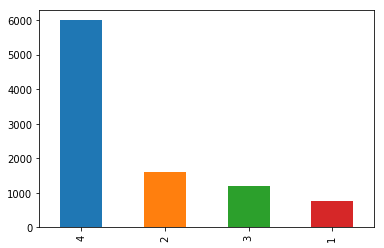

In [7]:
train_pd.Target.value_counts().plot(kind='bar')

In [8]:
# compute the disbalance
print(train_pd.Target.value_counts())
print(train_pd.Target.value_counts(normalize=True))
print(len(train_pd))

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64
4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64
9557


# Define the network

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils import vis_utils

def instantiate_model():
    m = Sequential([
        Dense(units=60, input_shape=(132,), activation='relu', use_bias=True, kernel_initializer='glorot_normal'),
        Dense(units=40, activation='relu', use_bias=True, kernel_initializer='glorot_normal'),
        Dropout(rate=0.3),
        Dense(units=10, activation='relu', use_bias=True, kernel_initializer='glorot_normal'),
        Dropout(rate=0.1),
        Dense(units=4, activation='softmax', use_bias=True, kernel_initializer='glorot_normal')
    ])
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return m

# define custom F1 metric
# taken from https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        Tracer()() 
        _val_f1 = f1_score(val_targ, val_predict, average="macro")
        _val_recall = recall_score(val_targ, val_predict, average="macro")
        _val_precision = precision_score(val_targ, val_predict, average="macro")

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" - val_f1: %f | val_precision: %f | val_recall %f"%(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()



In [46]:
# prepare the data
# split 

# convert all NaNs to 0 - big assumption
train_pd = train_pd.fillna(0)
#

input_train, input_test, \
target_train, target_test = train_test_split(train_pd.loc[:, ~train_pd.columns.isin(['idhogar', 'Id', 'Target'])].values,
                                             train_pd['Target'].values,
                                             train_size=0.7)

# now resample 
def SMOTE_resample(x, y):
    max_label = pd.Series(y).value_counts().iloc[0]
    sm = SMOTE(random_state=42, ratio={1:max_label, 2:max_label, 3:max_label})
    x_res, y_res = sm.fit_sample(x, y)
    return x_res, y_res

input_train2, target_train2 = SMOTE_resample(input_train, target_train)


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [57]:
model = instantiate_model()

model.fit(input_train2, np_utils.to_categorical(target_train2-1), 
          validation_data = (input_test, np_utils.to_categorical(target_test-1)),
          epochs = 100, verbose = 1,
         callbacks = [metrics])

# 0, 0, 0, 1 - not represented
# 0, 0, 1, 0 - not represented
# 1, 0, 0, 0 - barely represented
# 0, 1, 0, 0 - overwhelmingly represented - target 4

Train on 16784 samples, validate on 2868 samples
Epoch 1/100
16784/16784 [==============================] - 2s 117us/step - loss: 5.2545 - acc: 0.2505 - val_loss: 5.0969 - val_acc: 0.0760


C:\Users\M0205192\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`


> <ipython-input-45-02eb4497e060>(32)on_epoch_end()
     30         val_targ = self.validation_data[1]
     31         Tracer()()
---> 32         _val_f1 = f1_score(val_targ, val_predict, average="macro")
     33         _val_recall = recall_score(val_targ, val_predict, average="macro")
     34         _val_precision = precision_score(val_targ, val_predict, average="macro")

ipdb> q
Exiting Debugger.


In [ ]:
#  val_f1: 0.235240 | val_precision: 0.584472 | val_recall 0.207276

In [58]:
len(input_train2)

16784

In [49]:
np_utils.to_categorical(np.array([0,1,2,3]))

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [50]:
target_train2

array([4, 4, 4, ..., 3, 3, 3], dtype=int64)

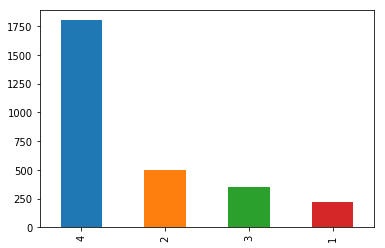

In [54]:
pd.Series(target_test).value_counts().plot(kind='bar')

In [52]:
input_train2

array([[0.00000000e+00, 0.00000000e+00, 4.00000000e+00, ...,
        4.00000000e+00, 1.44000000e+02, 9.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.00000000e+00, ...,
        1.00000000e+00, 6.40000000e+01, 3.84400000e+03],
       [0.00000000e+00, 0.00000000e+00, 6.00000000e+00, ...,
        2.25000000e+00, 1.04039990e+02, 4.00000000e+02],
       ...,
       [6.00000000e+04, 0.00000000e+00, 3.16953231e+00, ...,
        8.38780001e+00, 1.17609354e+02, 5.91093538e+02],
       [0.00000000e+00, 0.00000000e+00, 4.00000000e+00, ...,
        5.38966016e+00, 4.35485254e+01, 1.22500000e+03],
       [0.00000000e+00, 0.00000000e+00, 4.77147334e+00, ...,
        7.07053310e-01, 5.06568182e+01, 1.44400000e+03]])